# Стратификация. Как разбиение выборки повышает чувствительность A/B теста

### ***Ноутбук из публикации "Стратификация. Как разбиение выборки повышает чувствительность A/B теста", X5RetailGroup, Хабр. Авторы Николай Назаров, Александр Сахнов***

In [1]:
import pandas as pd
import numpy as np    
from scipy import stats
from tqdm import tqdm
import seaborn as sns

### **Размер выборки**

In [2]:
alpha = 0.05                    # вероятность ошибки I рода
beta = 0.2                      # вероятность ошибки II рода
mu_control = 2500               # средняя выручка с пользователя в контрольной группе
effect = 100                    # размер эффекта
mu_pilot = mu_control + effect  # средняя выручка с пользователя в экспериментальной группе
std = 800                       # стандартное отклонение

t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
var = 2 * std ** 2
sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
print(f'sample_size = {sample_size}')

sample_size = 1004


### **Проверим, что при таком размере групп вероятности ошибок контролируются на заданных уровнях. Это можно сделать с помощью синтетических AA и AB тестов. Будем генерировать пары выборок с эффектом и без эффекта и считать доли случаев, когда тест Стьюдента ошибся.**

In [3]:
first_type_errors = []
second_type_errors = []
 
sample_size = 1004
 
for _ in tqdm(range(10000)):
    control_one = np.random.normal(mu_control, std, sample_size)
    control_two = np.random.normal(mu_control, std, sample_size)
    pilot = np.random.normal(mu_pilot, std, sample_size)
    _, pvalue_aa = stats.ttest_ind(control_one, control_two)
    first_type_errors.append(pvalue_aa < alpha)
    _, pvalue_ab = stats.ttest_ind(control_one, pilot)
    second_type_errors.append(pvalue_ab >= alpha)

part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print('--------------------------------------------')
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')

100%|██████████| 10000/10000 [00:17<00:00, 581.40it/s]

--------------------------------------------
part_first_type_errors = 0.047
part_second_type_errors = 0.195


### **Формирование тестовой и контрольной группы**

In [4]:
user_ids = np.arange(10000)
control_user_ids, pilot_user_ids = np.random.choice(
user_ids, (2, sample_size), replace=False
)

### **Ковариата - метрика, которая коррелирует с целевой метрикой, может быть измерена до эксперимента и не зависит от других экспериментов.**
### **Популяция - все пользователи, на которых мы можем повлиять нашим экспериментом.**
### **С помощью ковариат можно разделить популяцию на непересекающиеся подмножества, которые будут обладать уникальным набором значений ковариат - стратами.**


In [5]:
def get_stratified_data(strat_to_param, effect=0):
    """Генерирует данные стратифицированным семплированием.

    Возвращает датафрейм со значениями метрики и страт пользователей
    в контрольной и экспериментальной группах.

    strat_to_param - словарь с параметрами страт
    effect - размер эффекта
    """
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        control += [
            (x, strat,) for x in np.random.normal(mu, std, n)
        ]
        pilot += [
            (x, strat,) for x in np.random.normal(mu + effect, std, n)
        ]
    columns = ['value', 'strat']
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df

In [6]:
def get_random_data(strats, sample_size, strat_to_param, effect=0):
    """Генерирует данные случайным семплированием.

    Возвращает датафрейм со значениями метрики и страт пользователей
    в контрольной и экспериментальной группах.

    strats - cписок страт в популяции
    sample_size - размеры групп
    strat_to_param - словарь с параметрами страт
    effect - размер эффекта
    """
    control_strats, pilot_strats = np.random.choice(
        strats, (2, sample_size), False
    )
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        n_control_ = np.sum(control_strats == strat)
        control += [
            (x, strat,) for x in np.random.normal(mu, std, n_control_)
        ]
        n_pilot_ = np.sum(pilot_strats == strat)
        pilot += [
            (x, strat,) for x in np.random.normal(mu + effect, std, n_pilot_)
        ]
    columns = ['value', 'strat']
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df

In [7]:
def ttest(a: pd.DataFrame, b: pd.DataFrame) -> float:
    """Возвращает pvalue теста Стьюдента.
  
    a, b - данные пользователей контрольной и экспериментальной групп
    """
    _, pvalue = stats.ttest_ind(a['value'].values, b['value'].values)
    return pvalue

In [8]:
alpha = 0.05                        # уровень значимости
N = 10000                           # количество пользователей в популяции
w_one, w_two = 0.5, 0.5             # доли страт в популяции
N_one = int(N * w_one)              # количество пользователей первой страты
N_two = int(N * w_two)              # количество пользователей второй страты
mu_one, mu_two = 2000, 3000         # средние выручки в стратах
std_one, std_two = 625, 625         # стандартное отклонение в стратах

# список страт в популяции
strats = [1 for _ in range(N_one)] + [2 for _ in range(N_two)]

# размер групп эксперимента
sample_size = 1100
sample_size_one = int(sample_size * w_one)
sample_size_two = int(sample_size * w_two)

# маппинг параметров страт
strat_to_param = {
    1: (sample_size_one, mu_one, std_one,),
    2: (sample_size_two, mu_two, std_two,)
}

random_first_type_errors = []
stratified_first_type_errors = []
random_deltas = []
stratified_deltas = []

for _ in tqdm(range(10000)):
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param
    )
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param
    )
    random_deltas.append(
        pilot_random['value'].mean() - control_random['value'].mean()
    )
    stratified_deltas.append(
        pilot_stratified['value'].mean() - control_stratified['value'].mean()
    )

    pvalue_random = ttest(control_random, pilot_random)
    random_first_type_errors.append(pvalue_random < alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_first_type_errors.append(pvalue_stratified < alpha)
 
part_random_first_type_errors = np.mean(random_first_type_errors)
part_stratified_first_type_errors = np.mean(stratified_first_type_errors)
print('--------------------------------------------')
print(f'part_random_first_type_errors = {part_random_first_type_errors:0.3f}')
print(f'part_stratified_first_type_errors = {part_stratified_first_type_errors:0.3f}')

100%|██████████| 10000/10000 [01:31<00:00, 109.88it/s]

--------------------------------------------
part_random_first_type_errors = 0.047
part_stratified_first_type_errors = 0.012


###**Стратифицированное семплирование снизило вероятность ошибки первого рода более чем в 4 раза**

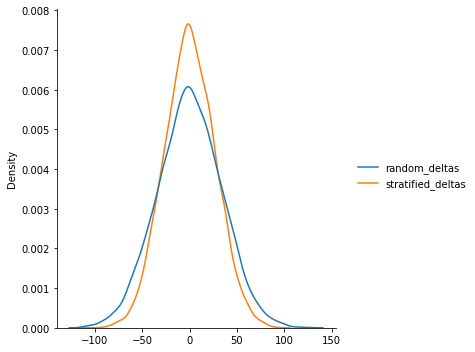

In [9]:
sns.displot(
    {'random_deltas': random_deltas, 'stratified_deltas': stratified_deltas},
    kind='kde'
)

In [10]:
effect = 100
random_second_type_errors = []
stratified_second_type_errors = []

for _ in tqdm(range(10000)):
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param, effect
    )
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param, effect
    )
    pvalue_random = ttest(control_random, pilot_random)
    random_second_type_errors.append(pvalue_random >= alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_second_type_errors.append(pvalue_stratified >= alpha)
 
part_random_second_type_errors = np.mean(random_second_type_errors)
part_stratified_second_type_errors = np.mean(stratified_second_type_errors)
print('--------------------------------------------')
print(f'part_random_second_type_errors = {part_random_second_type_errors:0.3f}')
print(f'part_stratified_second_type_errors = {part_stratified_second_type_errors:0.3f}')

100%|██████████| 10000/10000 [01:22<00:00, 121.13it/s]

--------------------------------------------
part_random_second_type_errors = 0.167
part_stratified_second_type_errors = 0.102


###**Получилось, что при случайном семплировании доля ошибок второго рода равна 0.167, а при стратифицированном - 0.109.**

### **Стратифицированное среднее**

In [11]:
def calc_strat_mean(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_mean = df.groupby('strat')['value'].mean()
    return (strat_mean * weights).sum()


In [12]:
def calc_strat_var(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированную дисперсию.
    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_var = df.groupby('strat')['value'].var()
    return (strat_var * weights).sum()


In [13]:
def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series) -> float:
    """Возвращает pvalue теста Стьюдента для стратифицированного среднего.

    a, b - данные пользователей контрольной и экспериментальной групп
    weights - маппинг {название страты: вес страты в популяции}
    """
    a_strat_mean = calc_strat_mean(a, weights)
    b_strat_mean = calc_strat_mean(b, weights)
    a_strat_var = calc_strat_var(a, weights)
    b_strat_var = calc_strat_var(b, weights)
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t = delta / std
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
    return pvalue

In [14]:
weights = pd.Series({1: w_one, 2: w_two})

first_type_errors = []
second_type_errors = []

for _ in tqdm(range(10000)):
    control_aa, pilot_aa = get_stratified_data(
        strat_to_param
    )
    control_ab, pilot_ab = get_stratified_data(
        strat_to_param, effect
    )

    pvalue_aa = ttest_strat(control_aa, pilot_aa, weights)
    first_type_errors.append(pvalue_aa < alpha)
    pvalue_ab = ttest_strat(control_ab, pilot_ab, weights)
    second_type_errors.append(pvalue_ab >= alpha)


part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print('--------------------------------------------')
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')

100%|██████████| 10000/10000 [02:50<00:00, 58.53it/s]

--------------------------------------------
part_first_type_errors = 0.051
part_second_type_errors = 0.038


###**Получаем долю ошибок I рода 0.05 и ошибок II рода 0.035. Теперь тест контролируют вероятность ошибки первого рода на заданном уровне значимости, но при этом его мощность значительно увеличилась.**